In [1]:
import os
import sys

abspath = os.path.abspath("")
sys.path.insert(0, os.path.join(abspath, "..", ".."))

import yaml

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

from infovar import DiscreteHandler
from infovar.stats.ranking import prob_higher
from infovar.stats.info_theory import corr_to_bits

%load_ext autoreload
%autoreload 2
# TODO

In [2]:
dataset = datasets.fetch_california_housing()

# print(dataset.feature_names)
# print(dataset.data.shape, end="\n\n")

# print(dataset.target_names)
# print(dataset.target.shape)

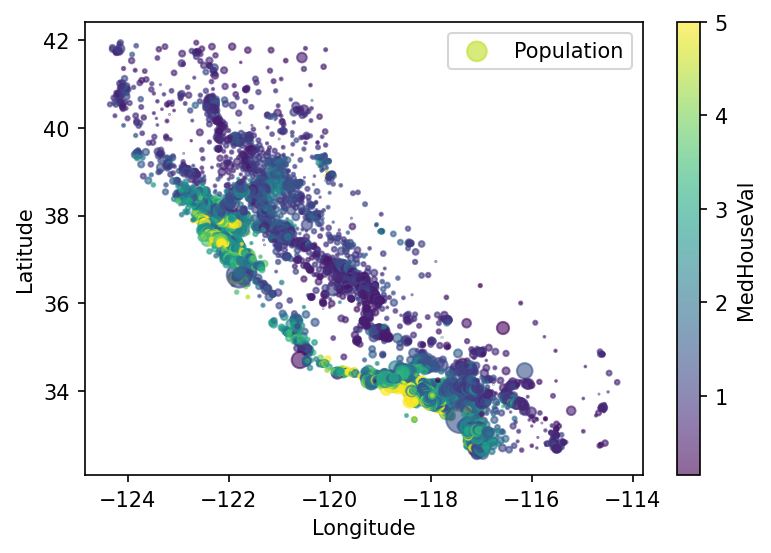

In [3]:
plt.figure(dpi=150)

housing = datasets.fetch_california_housing(as_frame=True).frame
housing.plot(kind="scatter", x="Longitude",y="Latitude", c="MedHouseVal", colorbar=True, legend=True, ax=plt.gca(), s=housing['Population']/200, label="Population", alpha=0.6)

plt.show()

In [4]:
# Filter data > 5
filt = dataset.target < 5

### Preprocessing

Preprocessing is not mandatory in this kind of analysis. Theoretically, the mutual information between variables $X$ and $Y$ is the same as that between $f(X)$ and $g(Y)$, for any bijections $f$ and $g$.

However, the non-parametric estimator may be sensitive to data spanning several orders of magnitude, for example. Ideally, we should try to reduce to data on a single order of magnitude, for example by applying a log, or another less sensitive operation such as $\mathrm{arcsinh}$.

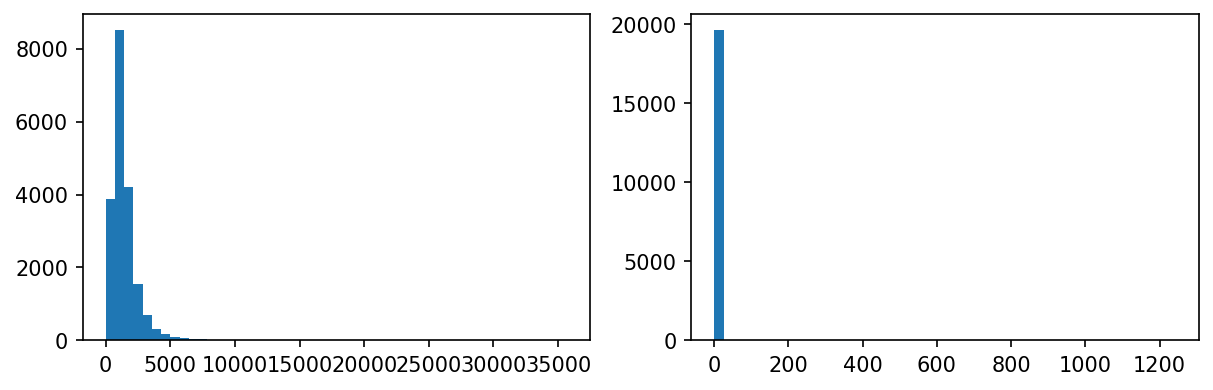

In [5]:
_variables = np.concatenate(
    [
        dataset.data[filt],
        np.random.normal(0, 1, size=(filt.sum(), 1)),
    ], axis=1
)
_targets = dataset.target[filt]

#

plt.figure(figsize=(1.5*6.4, 0.6*4.8), dpi=150)

plt.subplot(1, 2, 1)
plt.hist(_variables[:, 4], bins=50)

plt.subplot(1, 2, 2)
plt.hist(_variables[:, 5], bins=50)

plt.show()

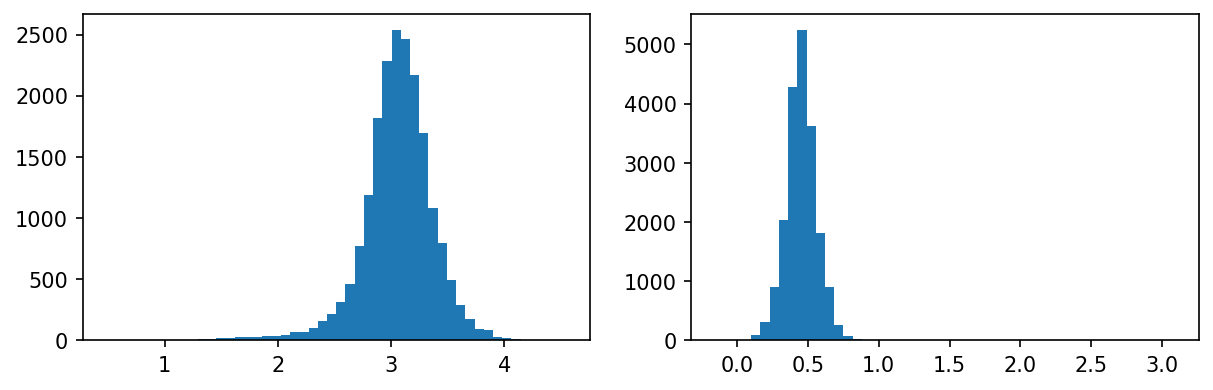

In [6]:
_variables[:, 4] = np.log10(_variables[:, 4]) # Population
_variables[:, 5] = np.log10(_variables[:, 5]) # AveOccup

#

plt.figure(figsize=(1.5*6.4, 0.6*4.8), dpi=150)

plt.subplot(1, 2, 1)
plt.hist(_variables[:, 4], bins=50)

plt.subplot(1, 2, 2)
plt.hist(_variables[:, 5], bins=50)

plt.show()

### Handler

In [7]:
save_path = os.path.join(abspath, "data-out")
ref_path = os.path.join(abspath, "reference.yaml")

handler = DiscreteHandler(
    variables=_variables,
    variable_names=dataset.feature_names + ["Noise"],
    targets=_targets,
    target_names=dataset.target_names,
    save_path=save_path,
    ref_path=ref_path
)

# Gérer le cas où on passe un pandas : pas besoin de variable_names, ils sont extraits par la suite

### Data analysis

In [8]:
handler.overview()

Variables:
	MedInc: [0.50, 15.00]
	HouseAge: [1.00, 52.00]
	AveRooms: [0.85, 132.53]
	AveBedrms: [0.33, 34.07]
	Population: [0.48, 4.55]
	AveOccup: [-0.16, 3.09]
	Latitude: [32.54, 41.95]
	Longitude: [-124.35, -114.31]
	Noise: [-4.56, 4.22]

Targets:
	MedHouseVal: [0.15, 4.99]

Number of samples: 19,648


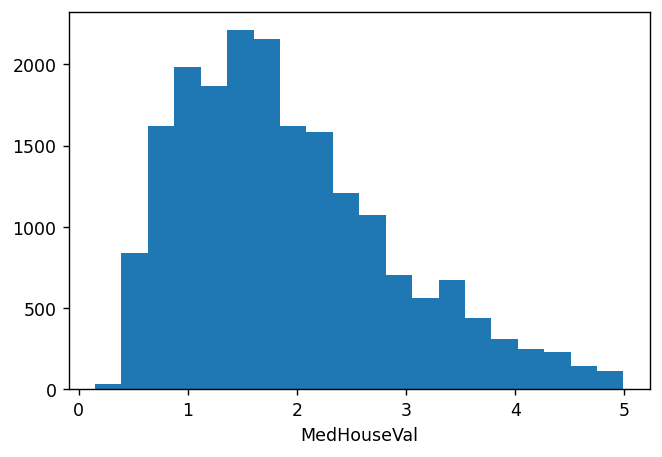

In [9]:
plt.figure(dpi=125)

plt.hist(dataset.target[filt], bins=20)
plt.xlabel(dataset.target_names[0])

plt.show()

## Informativity of each variable

### Statistics computation

In [10]:
with open(os.path.join(abspath, 'inputs-1.yaml'), 'r') as f:
    inputs_dict = yaml.safe_load(f)

In [11]:
handler.overwrite(
    inputs_dict
)

['MedHouseVal']: 100%|██████████| 9/9 [00:37<00:00,  4.15s/it, vars=['Noise']]     


### Results analysis

In [12]:
targs = ["MedHouseVal"]

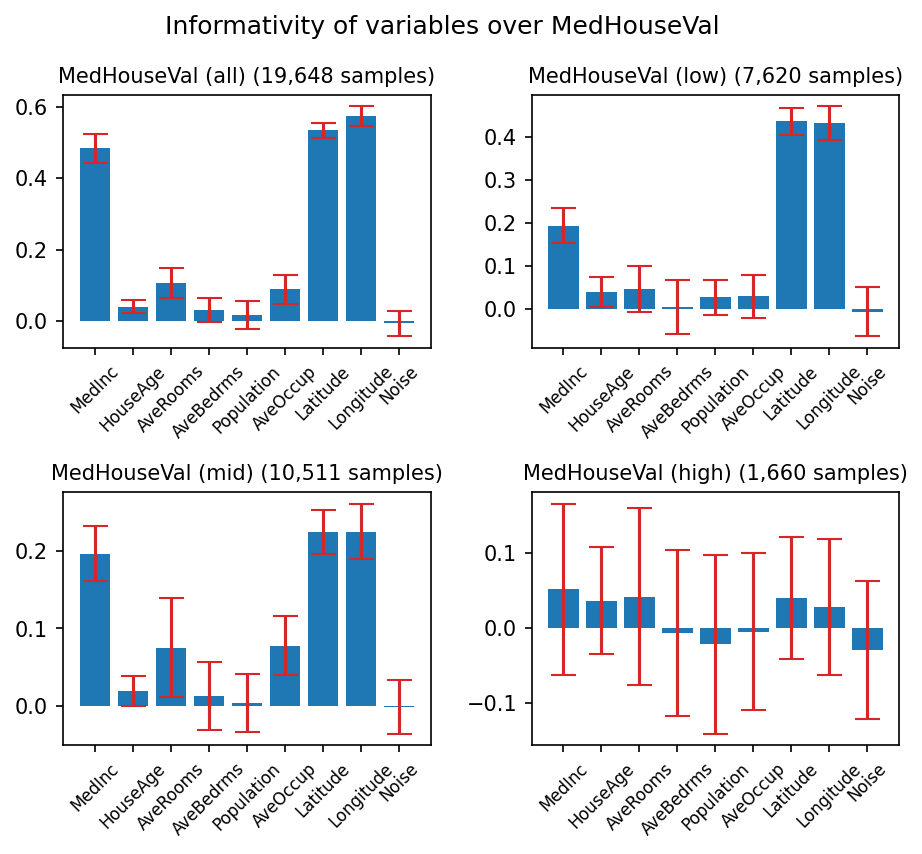

In [13]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=150)

plt.suptitle("Informativity of variables over MedHouseVal")

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    entries = [
        handler.read(targs, v, rgs) for v in handler.variable_names
    ]

    mis = [el["mi"] for el in entries]
    stds = [np.std(el["mi-boot"]) for el in entries]
    samples = entries[0]["samples"]

    #

    name = list(rgs.values())[0]
    xticks = list(range(len(entries)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, mis)
    plt.errorbar(xticks, mis, yerr=stds, fmt='none', capsize=6, color='tab:red')
    plt.xticks(xticks, labels=handler.variable_names, rotation=45, fontsize=8)

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

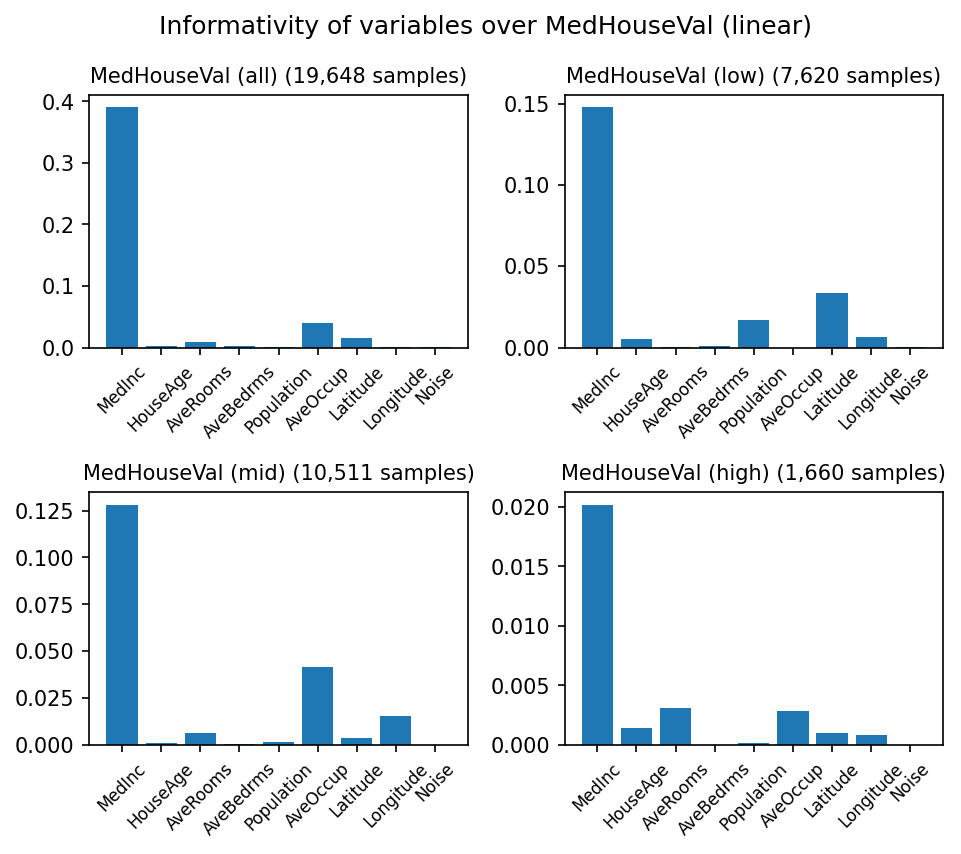

In [15]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=150)

plt.suptitle("Informativity of variables over MedHouseVal (linear)")

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    entries = [
        handler.read(targs, v, rgs) for v in handler.variable_names
    ]

    corrs = [el["corr"] for el in entries]
    stds = [np.std(el["corr-boot"]) for el in entries]
    samples = entries[0]["samples"]
    mis_g = corr_to_bits(np.array(corrs))

    #

    name = list(rgs.values())[0]
    xticks = list(range(len(entries)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, mis_g)
    # plt.bar(xticks, corrs)
    #plt.errorbar(xticks, corrs, yerr=stds, fmt='none', capsize=6, color='tab:red')
    plt.xticks(xticks, labels=handler.variable_names, rotation=45, fontsize=8)

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

### Identification of most informative variable(s)

In [ ]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=150)

plt.suptitle("Probability of being the most informative variable")

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    entries = [
        handler.read(targs, v, rgs) for v in handler.variable_names
    ]

    mis = [el["mi"] for el in entries]
    stds = [np.std(el["mi-boot"]) for el in entries]
    samples = entries[0]["samples"]

    #

    probs = prob_higher(mis, stds, approx=False)

    #

    name = list(rgs.values())[0]
    xticks = list(range(len(entries)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, probs)
    plt.xticks(xticks, labels=handler.variable_names, rotation=45, fontsize=8)
    plt.ylim([0, 1.05])

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

### Interpretation: latitude and longitude

In [ ]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=150)

plt.suptitle("MedHouseVal vs. latitude and longitude")

temp = {
    "all": None,
    "low": [None, 1.5],
    "mid": [1.5, 3.5],
    "high": [3.5, None]
}

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    vars, targs = handler._filter_data(
        vars= ["Latitude", "Longitude", "Population"],
        targs="MedHouseVal",
        ranges={key: temp[name] for key, name in rgs.items()}
    )

    #

    name = list(rgs.values())[0]
    xticks = list(range(len(entries)))

    plt.subplot(2, 2, i)

    plt.scatter(vars[:, 0], vars[:, 1], s=10*vars[:, 2], c=targs[:, 0])
    plt.gca().set_aspect("equal")

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import binned_statistic_2d

plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=150)

plt.suptitle("MedHouseVal vs. latitude and longitude")

temp = {
    "all": None,
    "low": [None, 1.5],
    "mid": [1.5, 3.5],
    "high": [3.5, None]
}

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    vars, targs = handler._filter_data(
        vars= ["Latitude", "Longitude"],
        targs="MedHouseVal",
        ranges={key: temp[name] for key, name in rgs.items()}
    )

    #

    ret = binned_statistic_2d(vars[:, 0], vars[:, 1], targs[:, 0], statistic=np.mean, bins=(50, 50))

    plt.subplot(2, 2, i)

    plt.imshow(ret.statistic.T, origin="lower")

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()


When you consider all the data, geographical position is essential. The figure above shows that most expensive homes are located in very specific areas.

When only expensive homes are considered, however, geographical location is no longer a determining factor. There doesn't seem to be any variable that is much more informative than the others.

## Informativity of a couple of two variables

### Statistics computation

In [ ]:
with open(os.path.join(abspath, 'inputs-2.yaml'), 'r') as f:
    inputs_dict = yaml.safe_load(f)

In [ ]:
handler.update(
    inputs_dict
)

### Results analysis

In [ ]:
targs = ["MedHouseVal"]

In [ ]:
import itertools as itt

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    comb_list = list(itt.combinations(handler.variable_names, 2))

    entries = [
        handler.read(targs, [v1, v2], rgs) for (v1, v2) in comb_list
    ]

    mis = [el["mi"] for el in entries]
    stds = [np.std(el["mi-boot"]) for el in entries]

    print(mis[-3]) # Print the MI for (Latitude, Longitude)

    probs = prob_higher(mis, stds)

    for cb, p in zip(comb_list, probs):
        print(f"{cb}: {p:.2f}")
    print()